In [5]:
%matplotlib inline
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression

In [6]:
class Dataset(object):
    def __init__(self, data):
        X, y = data
        X = StandardScaler().fit_transform(X)
        self.X = X
        self.y = y
        self.split()
        self.define_mesh()

    def split(self, test_size=0.4):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=test_size)
        self.X0 = X_train
        self.y0 = y_train
        self.X1 = X_test
        self.y1 = y_test
        
    def define_mesh(self, h=0.02):
        # h is the step size in the mesh
        x_min, x_max = self.X[:, 0].min() - .5, self.X[:, 0].max() + .5
        y_min, y_max = self.X[:, 1].min() - .5, self.X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h),
                                       np.arange(y_min, y_max, h))


class ModelCollection(object):
    def __init__(self):
        self.models = defaultdict(dict)
        self.scores = defaultdict(dict)

    def __str__(self):
        mystr = ''
        for ds_name, ds in self.models.iteritems():
            for model_name, model in ds.iteritems():
                score = self.scores[ds_name][model_name]
                mystr += '%s - %s\t%.2f\n' % (ds_name, model_name, score)
        return mystr
                
    def add_model(self, dataset_name, model_name, model, score):
        self.models[dataset_name][model_name] = model
        self.scores[dataset_name][model_name] = score 

    def get_model(self, dataset_name, model_name):
        return self.models[dataset_name][model_name]

    def get_score(self, dataset_name, model_name):
        return self.scores[dataset_name][model_name]

    def get_num_models(self, dataset_name):
        return len(self.models[dataset_name])

In [7]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)
datasets = { 'Moons': Dataset( make_moons(noise=0.3) ),
             'Circles': Dataset( make_circles(noise=0.2, factor=0.5) ),
             'Linearly Separable': Dataset( linearly_separable ) }

In [12]:
def make_classifiers():
    clf_names = ['Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Decision Tree',
                 'Random Forest', 'AdaBoost', 'Extra Trees', 'Naive Bayes', 'QDA',
                 'Logistic']
    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel='linear', C=0.025),
        SVC(gamma=2, C=1),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
        AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                           algorithm="SAMME", n_estimators=200),
        ExtraTreesClassifier(),
        GaussianNB(),
        QDA(),
        LogisticRegression()]

    classifier_dict = {}
    for name, clf in zip(clf_names, classifiers):
        yield name, clf


model_collection = ModelCollection()
for ds_name, ds in datasets.items():
    for clf_name, clf in make_classifiers():
        clf.fit(ds.X0, ds.y0) # fit training data
        score = clf.score(ds.X1, ds.y1) # compute predictive accuracy on test data
        model_collection.add_model(ds_name, clf_name, clf, score)

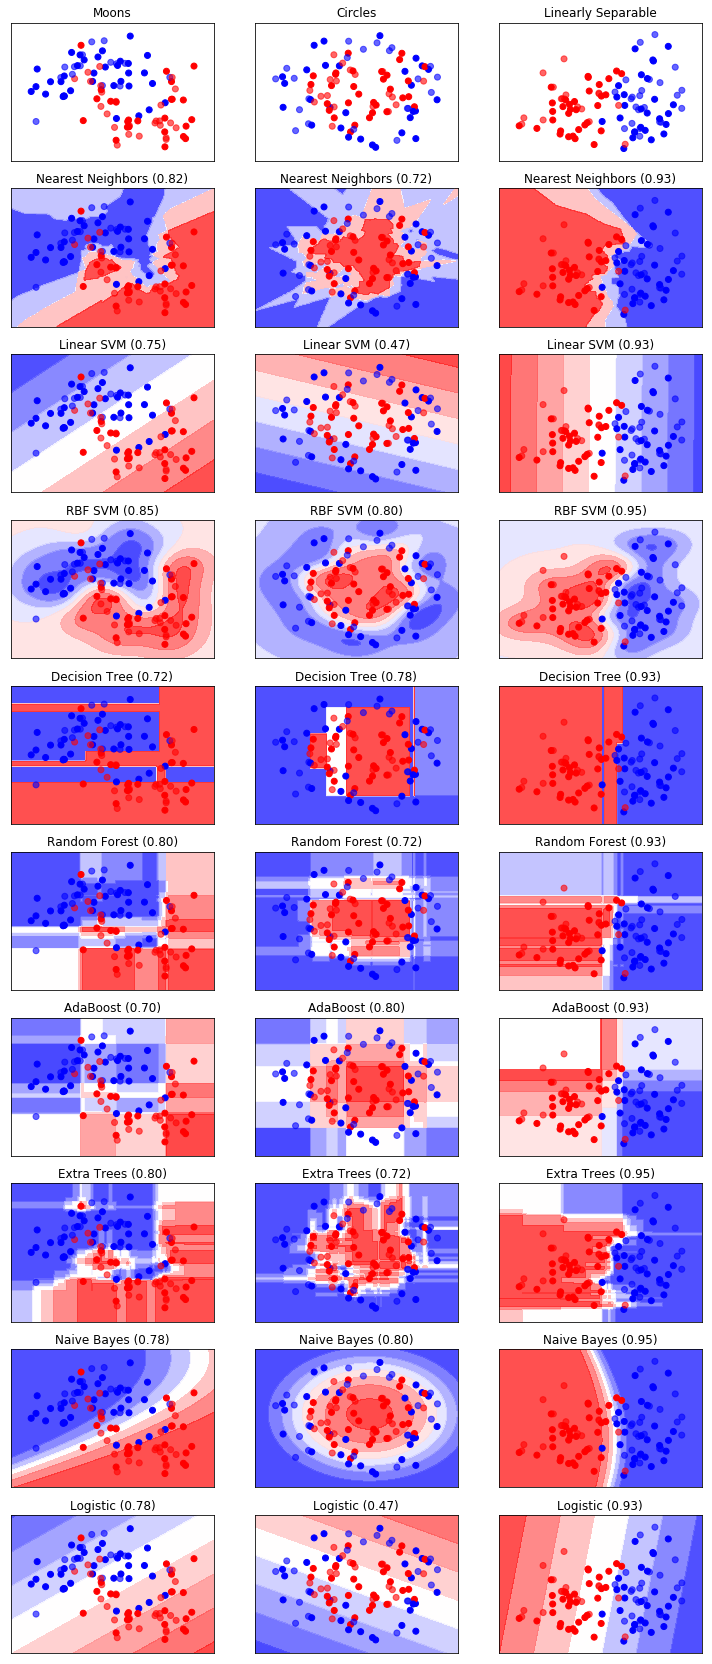

In [13]:
def plot_panel(ds_name, clf_name, model_collection, datasets, ax):
    ds = datasets[ds_name]
    if clf_name is None:
        ax.set_title("%s" % ds_name)
    else:
        model = model_collection.get_model(ds_name, clf_name)
        # Plot the decision boundary
        if hasattr(model, "decision_function"):
            Z = model.decision_function(np.c_[ds.xx.ravel(), ds.yy.ravel()])
        else:
            Z = model.predict_proba(np.c_[ds.xx.ravel(), ds.yy.ravel()])[:, 1]
        Z = Z.reshape(ds.xx.shape)
        ax.contourf(ds.xx, ds.yy, Z, cmap=cm, alpha=0.8)
        score = model_collection.get_score(ds_name, clf_name)
        ax.set_title("%s (%.2f)" % (clf_name, score))

    # Plot the data points
    ax.scatter(ds.X0[:, 0], ds.X0[:, 1], c=ds.y0, cmap=cm_bright)
    ax.scatter(ds.X1[:, 0], ds.X1[:, 1], c=ds.y1, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(ds.xx.min(), ds.xx.max())
    ax.set_ylim(ds.yy.min(), ds.yy.max())
    ax.set_xticks(())
    ax.set_yticks(())


cm = plt.cm.bwr
cm_bright = ListedColormap(['#0000FF', '#FF0000'])

ds_cols = ['Moons', 'Circles', 'Linearly Separable']
clf_rows = ['Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Decision Tree',
            'Random Forest', 'AdaBoost', 'Extra Trees', 'Naive Bayes',
            'Logistic']

figure, axes = plt.subplots(len(clf_rows) + 1, len(ds_cols), figsize=(10, 30))

for j, d in enumerate(ds_cols):
    plot_panel(d, None, model_collection, datasets, axes[0, j])

for i, c in enumerate(clf_rows):
    for j, d in enumerate(ds_cols):
        plot_panel(d, c, model_collection, datasets, axes[i+1, j])

figure.subplots_adjust(left=.02, right=.98)

# 